# Evaluating the Agents

First, a simulator to compare the agents must be built:

In [1]:
from Blackjack.Round import Round
from Blackjack.Dealer import Dealer
from Blackjack.Action import Action
from Blackjack.Agent.MonteCarloOnPolicyAgent import MonteCarloOnPolicyAgent
from Blackjack.Agent.SarsaOnPolicyAgent import SarsaOnPolicyAgent
from Blackjack.Agent.DoubleQOffPolicyAgent import DoubleQOffPolicyAgent
from Blackjack.Agent.Agent import Agent
from Blackjack.Action import Action

class AgentSimulator():
    def __init__(self, agent: Agent):
        self.agent = agent
        self.round = None

    def play_round(self):
        self.round = Round()

        action = Action.HIT

        while action == Action.HIT and self.round.get_terminal_state() is None and self.round.get_sum_for_player(True) [0] != 21:
            action = self.agent.get_policy(self.round.get_agent_state())

            if action == Action.HIT:
                self.round.hit()
            elif action == Action.STAND:
                self.round.stand()

            if isinstance(self.agent, SarsaOnPolicyAgent): # agents which update after each action (SARSA)
                self.agent.update_agent(self.round, self.agent.get_policy(self.round.get_agent_state()), self.round.get_terminal_state())
            elif isinstance(self.agent, DoubleQOffPolicyAgent): # agents which update after each action (Double Q)
                self.agent.update_agent(self.round, self.agent.get_policy(self.round.get_agent_state()), self.round.get_terminal_state())

        # loss, agent sum went over 21
        if self.round.get_terminal_state() is not None: 
            # agents which update at the end of the episode (Monte Carlo) need to be updated
            # note that agents which update after each action (SARSA) already updated after applying the action resulting in a loss
            if isinstance(self.agent, MonteCarloOnPolicyAgent):
                self.agent.update_agent(self.round)

            self.agent.end_episode()

            return self.round.get_terminal_state(True)
        
        # switching turns
        if self.round.get_sum_for_player(True) [0] == 21:
            self.round.stand() # change turn to dealer

        dealer = Dealer()

        while dealer.get_policy(self.round.get_sum_for_player(False) [0]) == Action.HIT and self.round.get_terminal_state() == None:
            self.round.hit()

        # updating agents
        if isinstance(self.agent, MonteCarloOnPolicyAgent):
            self.agent.update_agent(self.round)
        elif isinstance(self.agent, SarsaOnPolicyAgent):
            self.agent.update_agent(self.round, Action.STAND, self.round.get_terminal_state(True))
        elif isinstance(self.agent, DoubleQOffPolicyAgent):
            self.agent.update_agent(self.round, self.agent.get_policy(self.round.get_agent_state()), self.round.get_terminal_state())


        self.agent.end_episode()

        return self.round.get_terminal_state(True)

    def simulate_games(self, num_games):
        results = []

        for _ in range(int(num_games / 1000)):
            results.append({
                "wins": 0,
                "losses": 0,
                "draws": 0
            })

            for _ in range(1000):
                result = self.play_round()

                if result == 1:
                    results [-1] ["wins"] += 1
                elif result == -1:
                    results [-1] ["losses"] += 1
                else:
                    results [-1] ["draws"] += 1

        return results

Defining functions to properly display the agents' results:

In [2]:
import matplotlib.pyplot as plt

def plot_results(results, title):
    x = list(range(0, len(results) * 1000, 1000))

    wins = [result ["wins"] for result in results]
    losses = [result ["losses"] for result in results]
    draws = [result ["draws"] for result in results]

    plt.plot(x, wins, label = "Wins", color = "#56e364")
    plt.plot(x, losses, label = "Losses", color = "#d12e2e")
    plt.plot(x, draws, label = "Draws", color = "#2e36d1")

    plt.xlabel("Episode Count")
    plt.ylabel("No. of Games")

    plt.title(title)
    plt.grid()
    plt.legend(loc = "lower right")

In [3]:
def plot_state_action_counts(state_action_counts, title):
    # TODO: no idea how to show the states in a readable way
    # TODO: Alright buddy

    # get top 50 most common state-action pairs
    # state_action_counts = dict(sorted(state_action_counts.items(), key = lambda x: x [1], reverse = True) [:50])

    labels = []
    counts = []

    for state_action, count in state_action_counts.items():
        state_dict = dict(state_action [0])

        label = f"sum {state_dict ['agent_sum']} card {state_dict ['dealer_card']} uses_ace {state_dict ['uses_ace']} {state_action [1]}"
        labels.append(label)

        counts.append(count)

    sorted_labels_counts = sorted(zip(labels, counts), key = lambda x: x [1], reverse = True)
    sorted_labels, sorted_counts = zip(*sorted_labels_counts)

    plt.bar(sorted_labels, sorted_counts, color = "#2e36d1")

    plt.ylabel("State-Action Count")

    plt.title(title)

In [4]:
def generate_strategy_table(agent: Agent, uses_ace):
    strategy_table = []

    dealer_cards = range(2, 12)
    player_sums = list(range(12, 21))

    for player_sum in player_sums:
        row = [player_sum]

        for dealer_card in dealer_cards:
            state = {
                "agent_sum": player_sum,
                "dealer_card": dealer_card,
                "uses_ace": uses_ace
            }

            action = agent.get_policy(state)

            if action == Action.HIT:
                row.append("H")
            elif action == Action.STAND:
                row.append("S")

        strategy_table.append(row)

    return strategy_table

In [5]:
def plot_total_state_action_counts(agents_n_counts, agents_descriptions, title):
    sums = []

    for agent_n_counts in agents_n_counts:
        sum = 0

        for count in agent_n_counts.values():
            sum += count

        sums.append(sum)

    plt.bar(agents_descriptions, sums, color = "blue")

    plt.ylabel("Total State-Action Count")
    plt.title(title)

## Monte-Carlo Evaluation:

Evaluating the Monte-Carlo On-Policy Agents:

In [6]:
mcop_agent_1 = MonteCarloOnPolicyAgent(True, 1) # exploring starts, epsilon is 1/k
mcop_agent_1_simulator = AgentSimulator(mcop_agent_1)
mcop_agent_1_results = mcop_agent_1_simulator.simulate_games(100000)

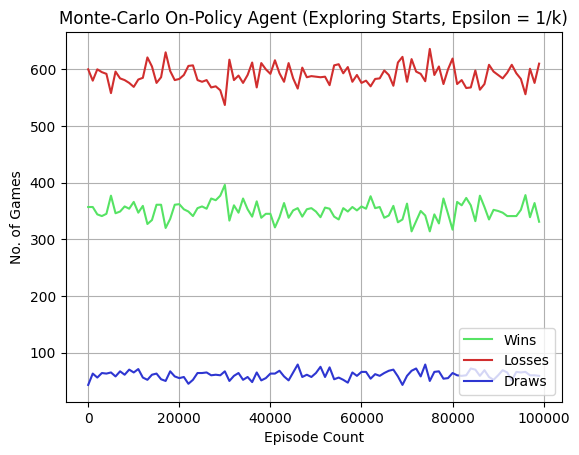

In [7]:
plot_results(mcop_agent_1_results, "Monte-Carlo On-Policy Agent (Exploring Starts, Epsilon = 1/k)")

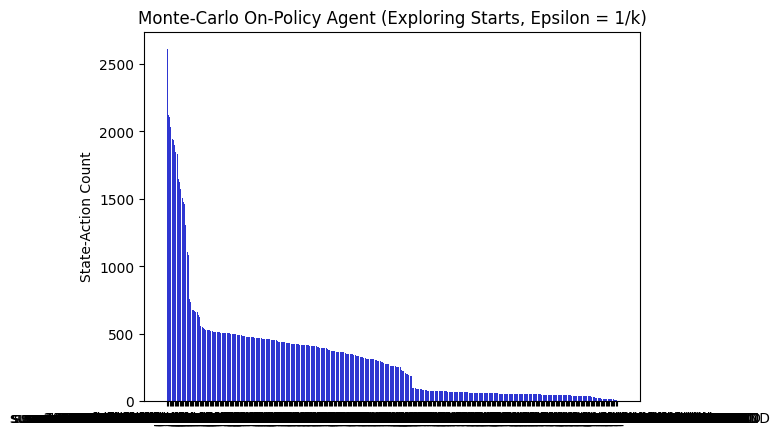

In [8]:
plot_state_action_counts(mcop_agent_1.n_counter, "Monte-Carlo On-Policy Agent (Exploring Starts, Epsilon = 1/k)")

In [9]:
import tabulate

strategy_table_mcop_1 = generate_strategy_table(mcop_agent_1, False)

strategy_table_mcop_1 = tabulate.tabulate(strategy_table_mcop_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (not using ace)")
print(strategy_table_mcop_1)

Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   

In [10]:
strategy_table_mcop_1 = generate_strategy_table(mcop_agent_1, True)
strategy_table_mcop_1 = tabulate.tabulate(strategy_table_mcop_1, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (using ace)")
print(strategy_table_mcop_1)

Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | S   | H   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | S   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H 

In [11]:
mcop_agent_2 = MonteCarloOnPolicyAgent(False, 1) # no exploring starts, epsilon is 1/k
mcop_agent_2_simulator = AgentSimulator(mcop_agent_2)
mcop_agent_2_results = mcop_agent_2_simulator.simulate_games(100000)

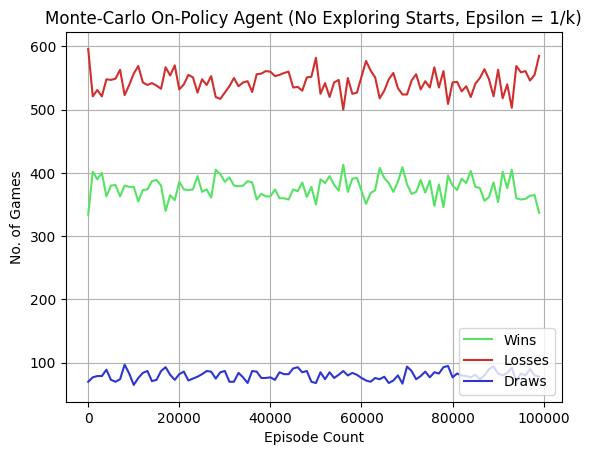

In [12]:
plot_results(mcop_agent_2_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = 1/k)")

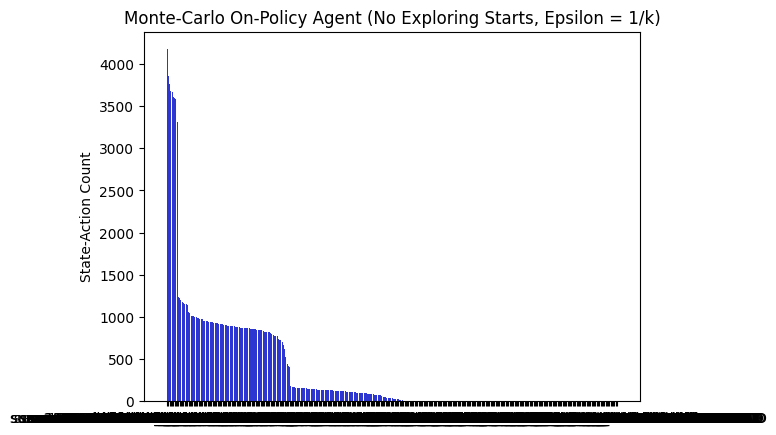

In [13]:
plot_state_action_counts(mcop_agent_2.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = 1/k)")

In [14]:
strategy_table_mcop_2 = generate_strategy_table(mcop_agent_2, False)

strategy_table_mcop_2 = tabulate.tabulate(strategy_table_mcop_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (not using ace)")
print(strategy_table_mcop_2)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | H   | H   | H   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | S   | S   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | H   | H   | H   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | H   | S   | H   | H   | H   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | S   | S   | H   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H

In [15]:
strategy_table_mcop_2 = generate_strategy_table(mcop_agent_2, True)
strategy_table_mcop_2 = tabulate.tabulate(strategy_table_mcop_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (using ace)")
print(strategy_table_mcop_2)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | S   | S   | H   | S   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   |

In [16]:
mcop_agent_3 = MonteCarloOnPolicyAgent(False, 2) # no exploring starts, epsilon is e^(-k/1000)
mcop_agent_3_simulator = AgentSimulator(mcop_agent_3)
mcop_agent_3_results = mcop_agent_3_simulator.simulate_games(100000)

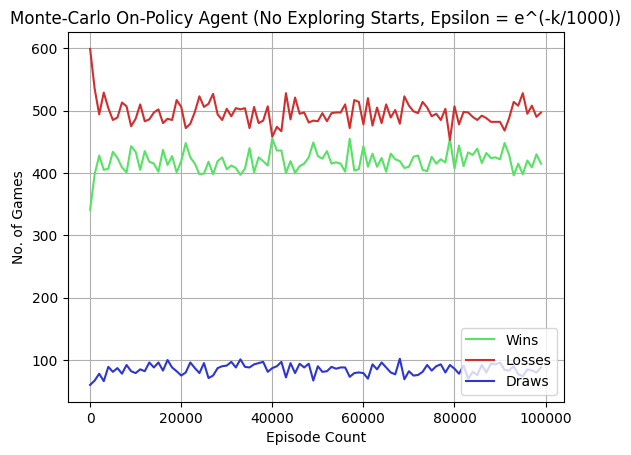

In [17]:
plot_results(mcop_agent_3_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/1000))")

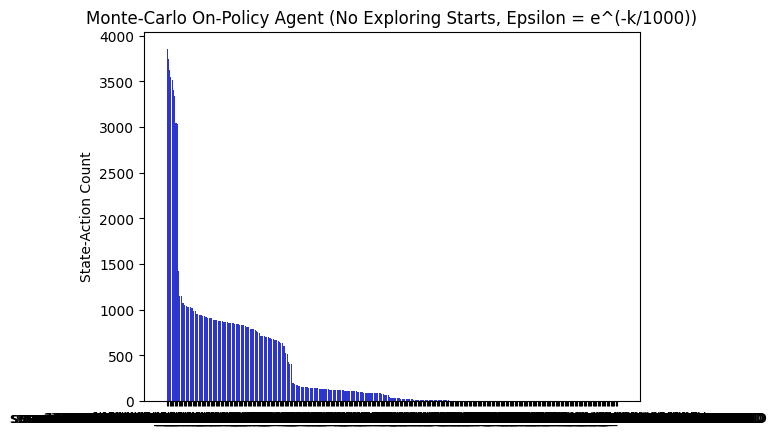

In [18]:
plot_state_action_counts(mcop_agent_3.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/1000))")

In [19]:
strategy_table_mcop_3 = generate_strategy_table(mcop_agent_3, False)
strategy_table_mcop_3 = tabulate.tabulate(strategy_table_mcop_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (not using ace)")
print(strategy_table_mcop_3)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | H   | S   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | H   | H   | H   | S   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | H   | H   | S   | S   | H   | H   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | H   | S   | S   | S   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 

In [20]:
strategy_table_mcop_3 = generate_strategy_table(mcop_agent_3, True)
strategy_table_mcop_3 = tabulate.tabulate(strategy_table_mcop_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (using ace)")
print(strategy_table_mcop_3)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | S   | H   | H   | H   | S   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | H   | H   | S   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | S   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 |

In [21]:
mcop_agent_4 = MonteCarloOnPolicyAgent(False, 3) # no exploring starts, epsilon is e^(-k/10000)
mcop_agent_4_simulator = AgentSimulator(mcop_agent_4)
mcop_agent_4_results = mcop_agent_4_simulator.simulate_games(100000)

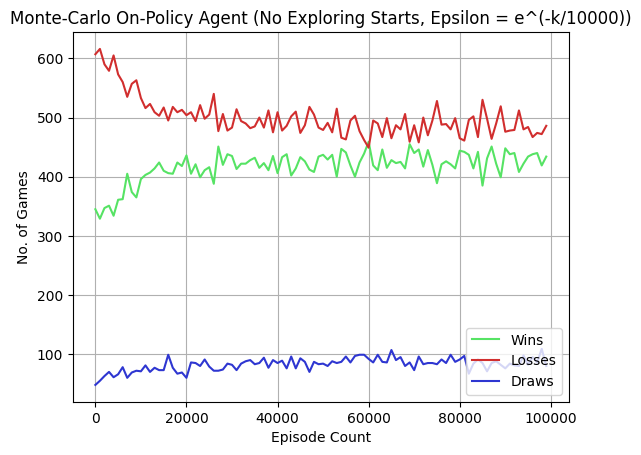

In [22]:
plot_results(mcop_agent_4_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/10000))")

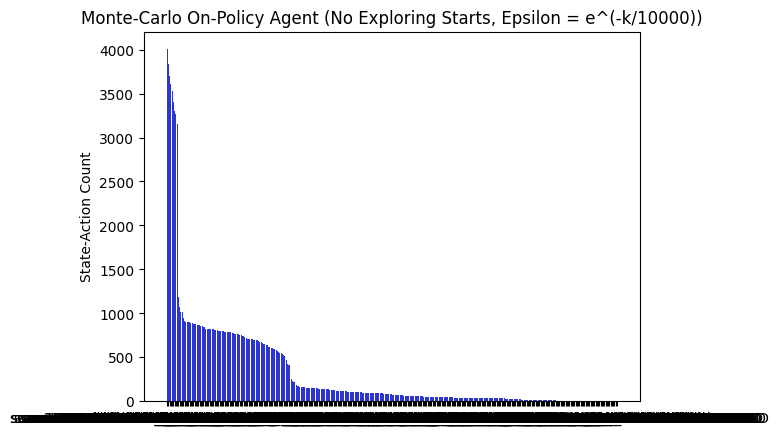

In [23]:
plot_state_action_counts(mcop_agent_4.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/10000))")

In [24]:
strategy_table_mcop_4 = generate_strategy_table(mcop_agent_4, False)
strategy_table_mcop_4 = tabulate.tabulate(strategy_table_mcop_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (not using ace)")
print(strategy_table_mcop_4)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | H   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|

In [25]:
strategy_table_mcop_4 = generate_strategy_table(mcop_agent_4, True)
strategy_table_mcop_4 = tabulate.tabulate(strategy_table_mcop_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (using ace)")
print(strategy_table_mcop_4)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | H   | H   | H   | H   | H   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 

Displaying the total number of unique state-action pairs across all configurations for Monte-Carlo On-Policy:

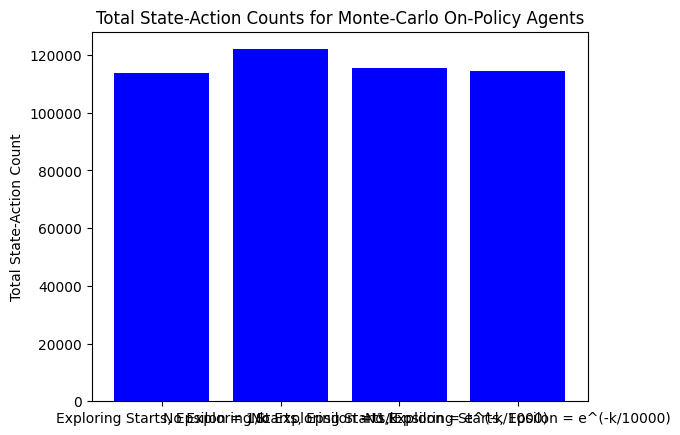

In [26]:
plot_total_state_action_counts(
    [mcop_agent_1.n_counter, mcop_agent_2.n_counter, mcop_agent_3.n_counter, mcop_agent_4.n_counter], 
    ["Exploring Starts, Epsilon = 1/k", "No Exploring Starts, Epsilon = 1/k", "No Exploring Starts, Epsilon = e^(-k/1000)", "No Exploring Starts, Epsilon = e^(-k/10000)"],
    "Total State-Action Counts for Monte-Carlo On-Policy Agents"
)

## SARSA Evaluation:

In [27]:
sarsa_agent_1 = SarsaOnPolicyAgent(1) # epsilon is 0.1
sarsa_agent_1_simulator = AgentSimulator(sarsa_agent_1)
sarsa_agent_1_results = sarsa_agent_1_simulator.simulate_games(100000)

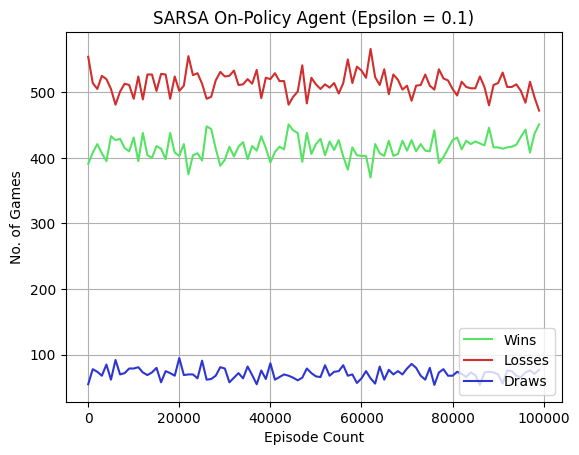

In [28]:
plot_results(sarsa_agent_1_results, "SARSA On-Policy Agent (Epsilon = 0.1)")

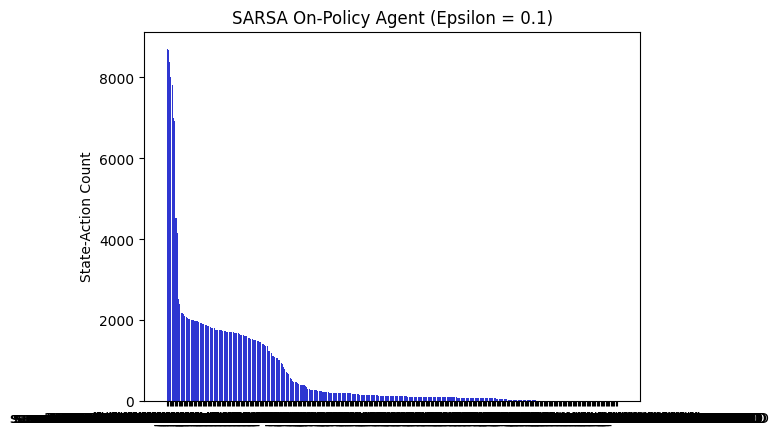

In [29]:
plot_state_action_counts(sarsa_agent_1.n_counter, "SARSA On-Policy Agent (Epsilon = 0.1)")

In [30]:
strategy_table_sarsa_1 = generate_strategy_table(sarsa_agent_1, False)
strategy_table_sarsa_1 = tabulate.tabulate(strategy_table_sarsa_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (not using ace)")
print(strategy_table_sarsa_1)

Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | S   | S   | S   | H   | H   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | S   | S   | S   | S   | H   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | H   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S   | S  

In [31]:
strategy_table_sarsa_1 = generate_strategy_table(sarsa_agent_1, True)
strategy_table_sarsa_1 = tabulate.tabulate(strategy_table_sarsa_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (using ace)")
print(strategy_table_sarsa_1)

Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | S   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | H   | H   | H   | H   | H   | H

In [32]:
sarsa_agent_2 = SarsaOnPolicyAgent(2) # epsilon is 1/k
sarsa_agent_2_simulator = AgentSimulator(sarsa_agent_2)
sarsa_agent_2_results = sarsa_agent_2_simulator.simulate_games(100000)

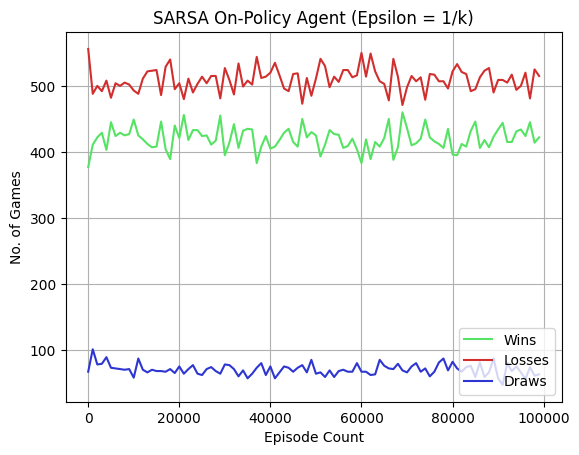

In [33]:
plot_results(sarsa_agent_2_results, "SARSA On-Policy Agent (Epsilon = 1/k)")

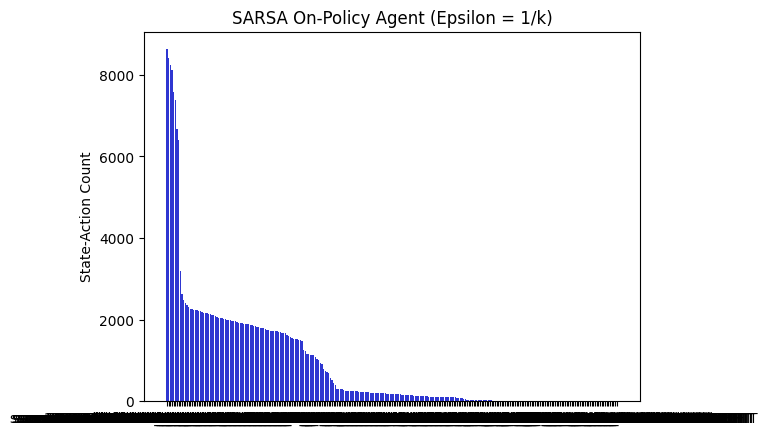

In [34]:
plot_state_action_counts(sarsa_agent_2.n_counter, "SARSA On-Policy Agent (Epsilon = 1/k)")

In [35]:
strategy_table_sarsa_2 = generate_strategy_table(sarsa_agent_2, False)
strategy_table_sarsa_2 = tabulate.tabulate(strategy_table_sarsa_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (not using ace)")
print(strategy_table_sarsa_2)

Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | H   | S   | H   | H   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S   | S  

In [36]:
strategy_table_sarsa_2 = generate_strategy_table(sarsa_agent_2, True)
strategy_table_sarsa_2 = tabulate.tabulate(strategy_table_sarsa_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (using ace)")
print(strategy_table_sarsa_2)

Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   | H   | H

In [37]:
sarsa_agent_3 = SarsaOnPolicyAgent(3) # epsilon is e^(-k/1000)
sarsa_agent_3_simulator = AgentSimulator(sarsa_agent_3)
sarsa_agent_3_results = sarsa_agent_3_simulator.simulate_games(100000)

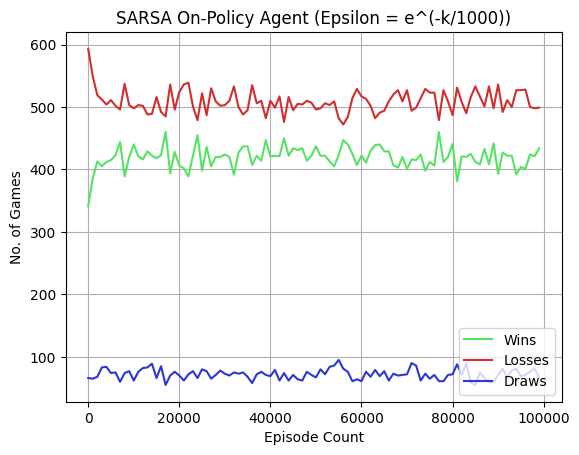

In [38]:
plot_results(sarsa_agent_3_results, "SARSA On-Policy Agent (Epsilon = e^(-k/1000))")

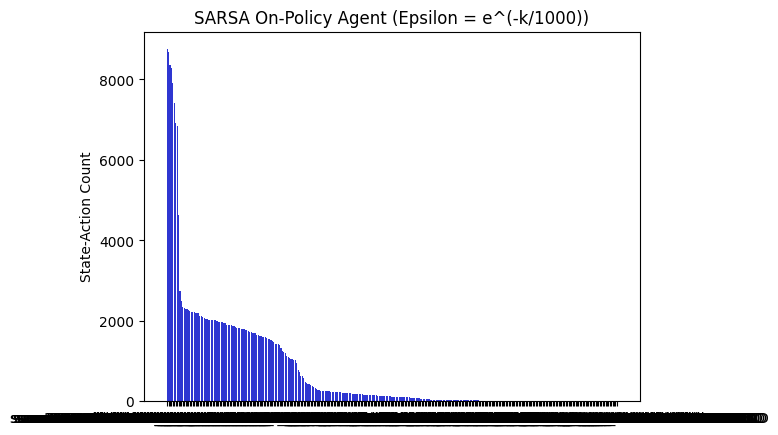

In [39]:
plot_state_action_counts(sarsa_agent_3.n_counter, "SARSA On-Policy Agent (Epsilon = e^(-k/1000))")

In [40]:
strategy_table_sarsa_3 = generate_strategy_table(sarsa_agent_3, False)
strategy_table_sarsa_3 = tabulate.tabulate(strategy_table_sarsa_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (not using ace)")
print(strategy_table_sarsa_3)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | S   | S   | S   | H   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | H   | S   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S

In [41]:
strategy_table_sarsa_3 = generate_strategy_table(sarsa_agent_3, True)
strategy_table_sarsa_3 = tabulate.tabulate(strategy_table_sarsa_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (using ace)")
print(strategy_table_sarsa_3)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | S   | H   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   |

In [42]:
sarsa_agent_4 = SarsaOnPolicyAgent(4) # epsilon is e^(-k/10000)
sarsa_agent_4_simulator = AgentSimulator(sarsa_agent_4)
sarsa_agent_4_results = sarsa_agent_4_simulator.simulate_games(100000)

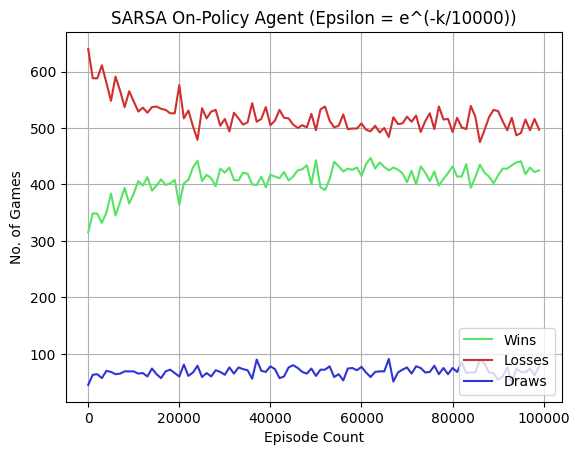

In [43]:
plot_results(sarsa_agent_4_results, "SARSA On-Policy Agent (Epsilon = e^(-k/10000))")

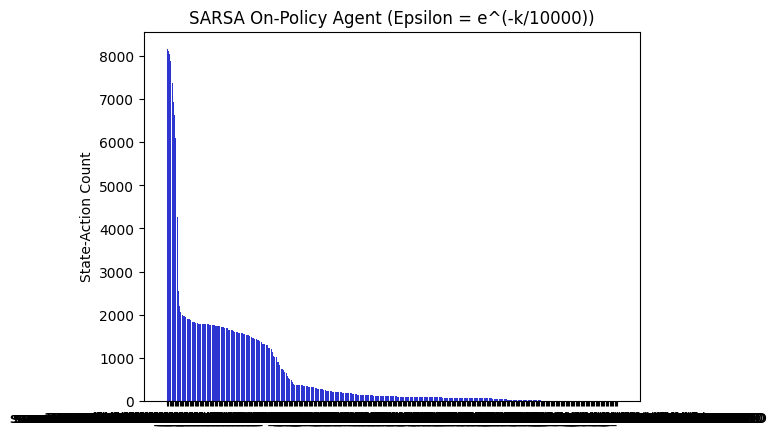

In [44]:
plot_state_action_counts(sarsa_agent_4.n_counter, "SARSA On-Policy Agent (Epsilon = e^(-k/10000))")

In [45]:
strategy_table_sarsa_4 = generate_strategy_table(sarsa_agent_4, False)
strategy_table_sarsa_4 = tabulate.tabulate(strategy_table_sarsa_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (not using ace)")
print(strategy_table_sarsa_4)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | H   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | 

In [46]:
strategy_table_sarsa_4 = generate_strategy_table(sarsa_agent_4, True)
strategy_table_sarsa_4 = tabulate.tabulate(strategy_table_sarsa_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (using ace)")
print(strategy_table_sarsa_4)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | H   | H   | S   | S   | H   | H   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | S   | H   | S   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | S   | H   | H   | S   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   

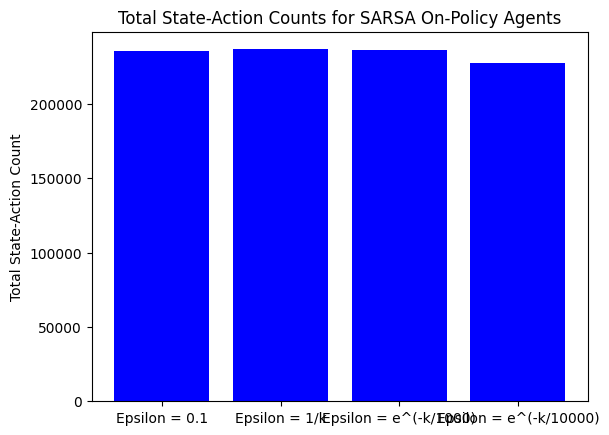

In [47]:
plot_total_state_action_counts([sarsa_agent_1.n_counter, sarsa_agent_2.n_counter, sarsa_agent_3.n_counter, sarsa_agent_4.n_counter], ["Epsilon = 0.1", "Epsilon = 1/k", "Epsilon = e^(-k/1000)", "Epsilon = e^(-k/10000)"], "Total State-Action Counts for SARSA On-Policy Agents")

## Double Q-Learning Evaluation:

In [48]:
dq_agent_1 = DoubleQOffPolicyAgent(1)  # epsilon is 0.1
dq_agent_1_simulator = AgentSimulator(dq_agent_1)
dq_agent_1_results = dq_agent_1_simulator.simulate_games(100000)

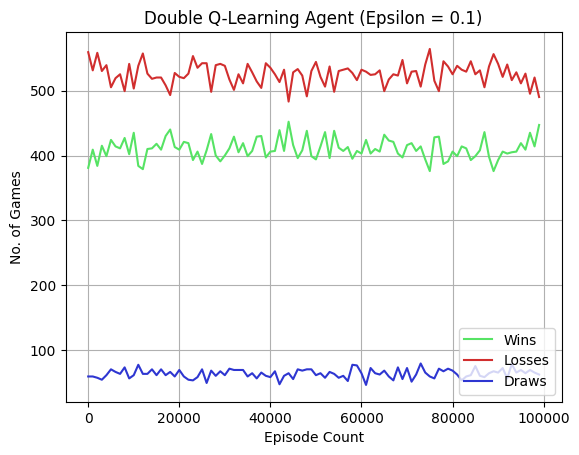

In [49]:
plot_results(dq_agent_1_results, "Double Q-Learning Agent (Epsilon = 0.1)")

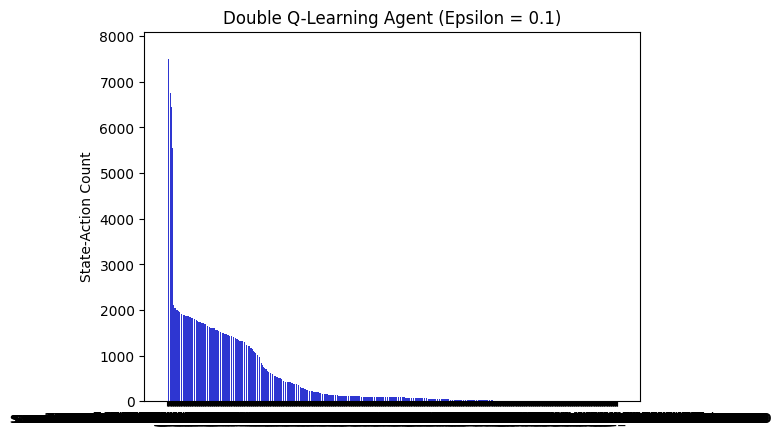

In [50]:
plot_state_action_counts(dq_agent_1.n_counter, "Double Q-Learning Agent (Epsilon = 0.1)")

In [51]:
strategy_table_dq_1 = generate_strategy_table(dq_agent_1, False)
strategy_table_dq_1 = tabulate.tabulate(strategy_table_dq_1, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

In [52]:
print("Strategy Table for Double Q-Learning Agent with Epsilon = 0.1 (not using ace)")
print(strategy_table_dq_1)

Strategy Table for Double Q-Learning Agent with Epsilon = 0.1 (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | H   | S   | S   | S   | S   | S   | S   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | H   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | S   | H   | S   | S   | S

In [53]:
strategy_table_dq_1 = generate_strategy_table(dq_agent_1, True)
strategy_table_dq_1 = tabulate.tabulate(strategy_table_dq_1, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

print("Strategy Table for Double Q-Learning Agent with Epsilon = 0.1 (using ace)")
print(strategy_table_dq_1)

Strategy Table for Double Q-Learning Agent with Epsilon = 0.1 (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | S   | H   | H   | H   | H   |

In [54]:
dq_agent_2 = DoubleQOffPolicyAgent(2)  # epsilon is 1/k
dq_agent_2_simulator = AgentSimulator(dq_agent_2)
dq_agent_2_results = dq_agent_2_simulator.simulate_games(100000)

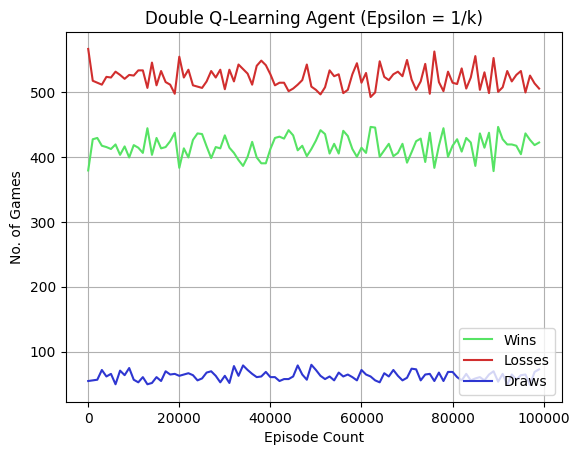

In [55]:
plot_results(dq_agent_2_results, "Double Q-Learning Agent (Epsilon = 1/k)")

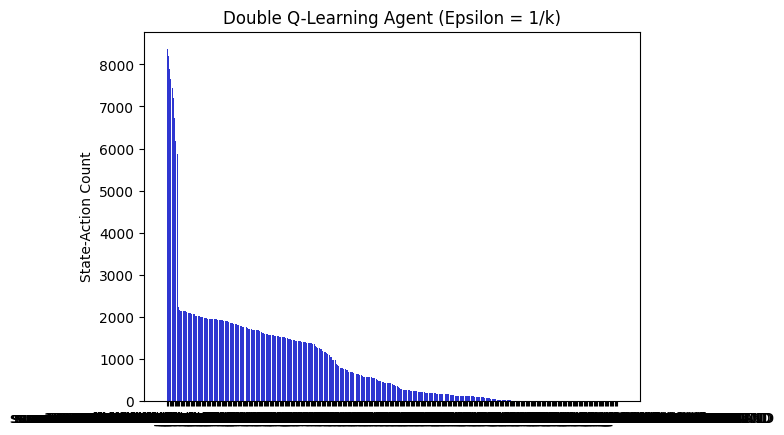

In [56]:
plot_state_action_counts(dq_agent_2.n_counter, "Double Q-Learning Agent (Epsilon = 1/k)")

In [57]:
strategy_table_dq_2 = generate_strategy_table(dq_agent_2, False)
strategy_table_dq_2 = tabulate.tabulate(strategy_table_dq_2, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")
print("Strategy Table for Double Q-Learning Agent with Epsilon = 1/k (not using ace)")
print(strategy_table_dq_2)

Strategy Table for Double Q-Learning Agent with Epsilon = 1/k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S   | S

In [58]:
strategy_table_dq_2 = generate_strategy_table(dq_agent_2, True)
strategy_table_dq_2 = tabulate.tabulate(strategy_table_dq_2, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")
print("Strategy Table for Double Q-Learning Agent with Epsilon = 1/k (using ace)")
print(strategy_table_dq_2)

Strategy Table for Double Q-Learning Agent with Epsilon = 1/k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   | H   |

In [59]:
dq_agent_3 = DoubleQOffPolicyAgent(3)  # epsilon is e^(-k/1000)
dq_agent_3_simulator = AgentSimulator(dq_agent_3)
dq_agent_3_results = dq_agent_3_simulator.simulate_games(100000)

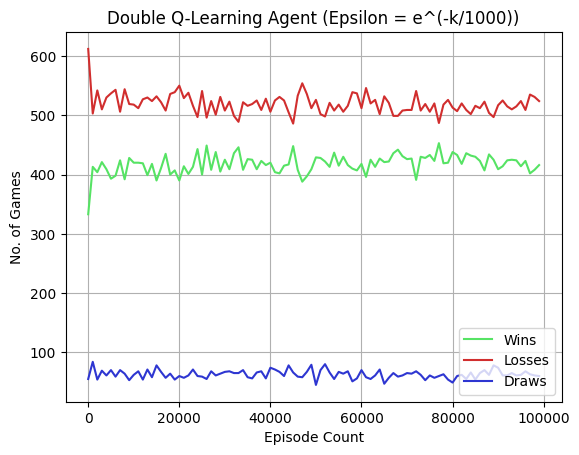

In [60]:
plot_results(dq_agent_3_results, "Double Q-Learning Agent (Epsilon = e^(-k/1000))")

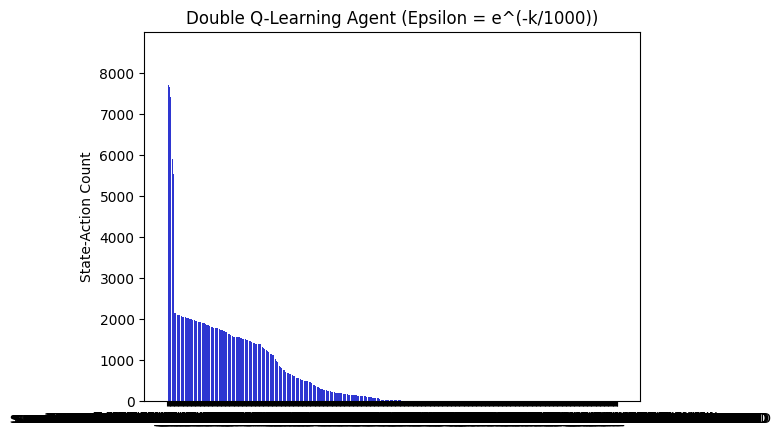

In [61]:
plot_state_action_counts(dq_agent_3.n_counter, "Double Q-Learning Agent (Epsilon = e^(-k/1000))")

In [62]:
strategy_table_dq_3 = generate_strategy_table(dq_agent_3, False)
strategy_table_dq_3 = tabulate.tabulate(strategy_table_dq_3, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

In [63]:
print("Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/1000) (not using ace)")
print(strategy_table_dq_3)

Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/1000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   |

In [64]:
strategy_table_dq_3 = generate_strategy_table(dq_agent_3, True)
strategy_table_dq_3 = tabulate.tabulate(strategy_table_dq_3, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

In [65]:

print("Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/1000) (using ace)")
print(strategy_table_dq_3)


Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/1000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H  

In [66]:
dq_agent_4 = DoubleQOffPolicyAgent(4)  # epsilon is e^(-k/10000)
dq_agent_4_simulator = AgentSimulator(dq_agent_4)
dq_agent_4_results = dq_agent_4_simulator.simulate_games(100000)


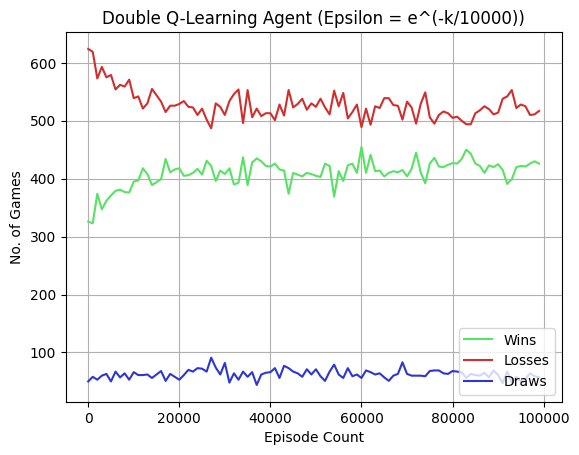

In [67]:
plot_results(dq_agent_4_results, "Double Q-Learning Agent (Epsilon = e^(-k/10000))")

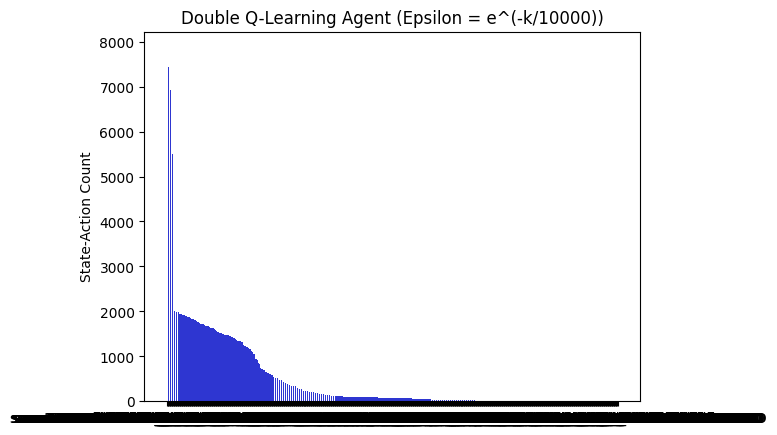

In [68]:
plot_state_action_counts(dq_agent_4.n_counter, "Double Q-Learning Agent (Epsilon = e^(-k/10000))")

In [69]:
strategy_table_dq_4 = generate_strategy_table(dq_agent_4, False)
strategy_table_dq_4 = tabulate.tabulate(strategy_table_dq_4, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

In [70]:
print("Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/10000) (not using ace)")
print(strategy_table_dq_4)

Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/10000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | H   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   

In [71]:
strategy_table_dq_4 = generate_strategy_table(dq_agent_4, True)
strategy_table_dq_4 = tabulate.tabulate(strategy_table_dq_4, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt="grid")

In [72]:
print("Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/10000) (using ace)")
print(strategy_table_dq_4)

Strategy Table for Double Q-Learning Agent with Epsilon = e^(-k/10000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H 

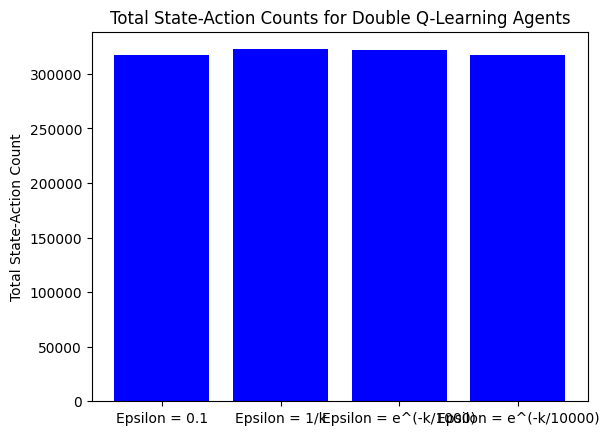

In [73]:
plot_total_state_action_counts(
    [dq_agent_1.n_counter, dq_agent_2.n_counter, dq_agent_3.n_counter, dq_agent_4.n_counter],
    ["Epsilon = 0.1", "Epsilon = 1/k", "Epsilon = e^(-k/1000)", "Epsilon = e^(-k/10000)"],
    "Total State-Action Counts for Double Q-Learning Agents"
)